In [1]:
import pandas as pd 
import numpy as np
import anndata as an
import scanpy as sc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from datasets import Dataset, load_from_disk, load_dataset
import geneformer

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(model_path, model_type='Pretrained', n_classes=0, mode='eval'):
    """
    Loads a pre-trained or custom model for geneformer perturbations.

    Args:
        model_path (str): Path to the model file.
        model_type (str, optional): Type of model ('Pretrained' or custom). Default: 'Pretrained'.
        n_classes (int, optional): Number of output classes for custom models. Default: 0.
        mode (str, optional): Mode to load the model in ('eval' or 'train'). Default: 'eval'.

    Returns:
        The loaded model object.
    """

    model = geneformer.perturber_utils.load_model(
        model_type,
        n_classes,
        model_path,
        mode
    )

    return model

model_path = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/pretrained_model/"
model = load_model(model_path)
print('loaded!')

loaded!


# load the data

In [3]:
def load_data_as_dataframe(data_path, num_cells=None, shuffle=False) -> pd.DataFrame:
    """Loads a dataset, optionally shuffles it, and returns a subset as a Pandas DataFrame.

    Args:
        data_path: Path to the dataset file.
        num_cells: Number of cells to include in the subset (default: 100).
        shuffle: Whether to shuffle the dataset before subsetting (default: True).

    Raises:
        ValueError: If the requested subset size exceeds the dataset length.

    Returns:
        The subset of data as a Pandas DataFrame.
    """

    data = load_from_disk(data_path)

    if shuffle:
        data = data.shuffle(seed=42)

    if num_cells is None:
        return data.to_pandas()
    elif num_cells > len(data):
        raise ValueError(f"Requested subset size ({num_cells}) exceeds dataset length ({len(data)}). For all cells, use num_cells=`None.'")
    else:
        data_subset = data.select([i for i in range(num_cells)])
        return data_subset.to_pandas()
    
    
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/tokenized_data/merged_adata.dataset"
sample_size = 10000
df = load_data_as_dataframe(
    fpath, 
    num_cells=sample_size, 
    shuffle=True,
)
print(f"{df.shape=}")
data = Dataset.from_pandas(df)
data

df.shape=(10000, 12)


Dataset({
    features: ['n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length'],
    num_rows: 10000
})

In [4]:
def extract_embedding_in_mem(model, data, emb_mode='cell', layer_to_quant=-1, forward_batch_size=10):
    """Extracts embeddings from a model and returns them as a DataFrame.

    This function provides an in-memory extraction of embeddings, allowing for convenient
    manipulation and analysis directly within your Python environment.

    Args:
        model: The model to use for embedding extraction.
        data: The input data for which embeddings need to be extracted.
        emb_mode (str, optional): The embedding mode. Defaults to 'cell'.
        layer_to_quant (int, optional): The layer to quantize. Defaults to -1 (last layer).
        forward_batch_size (int, optional): The batch size for forward passes. Defaults to 10.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted embeddings.

    Raises:
        TypeError: If `model` is not a supported model type.
        ValueError: If `data` is not in the correct format.
    """

    embs = geneformer.emb_extractor.get_embs(
        model,
        data,
        emb_mode,
        layer_to_quant,
        0,  # Assuming this is a constant parameter for the function
        forward_batch_size,
        summary_stat=None,  
        silent=False, 
    )
    data = embs.cpu().numpy()
    if emb_mode=='cell':
        return pd.DataFrame(data)
    else:
        return data
    
    
def embedding_to_adata(df: pd.DataFrame, n_dim: int = None) -> an.AnnData:
    """Converts a Pandas DataFrame with an embedding to an AnnData object.

    Args:
        df: The input DataFrame with numerical embedding columns and optional metadata columns.
        n_dim: The number of dimensions to keep in the embedding. If None, all dimensions are kept.

    Returns:
        The converted AnnData object.

    Raises:
        ValueError: If `n_dim` exceeds the available dimensions in the DataFrame.
    """

    if n_dim is not None and n_dim > df.shape[1]:
        raise ValueError(f"n_dim ({n_dim}) exceeds available dimensions ({df.shape[1]})")

    # Assuming embedding columns are those that are not integers
    is_metadata = df.columns.astype(str).str.isdigit()
    metadata_df = df.loc[:, ~is_metadata]
    embedding_df = df.loc[:, is_metadata]

    cell_index = pd.Index([f"C{x}" for x in range(df.shape[0])], name='obs_names')

    if n_dim is not None:
        embedding_df = embedding_df.iloc[:, :n_dim]

    var_index = pd.Index([f"D{x}" for x in range(embedding_df.shape[1])], name='var_names')

    adata = an.AnnData(embedding_df.to_numpy())
    adata.obs_names = cell_index
    adata.var_names = var_index
    adata.obs = metadata_df
    return adata
    

torch.cuda.empty_cache()
embs = extract_embedding_in_mem(
    model, 
    data, 
    layer_to_quant=-1,
)
print(f"{embs.shape=}")

embs = embedding_to_adata(embs)
embs.obs = df
embs.obs.head()

100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]

embs.shape=(10000, 512)


,n_genes,dataset_x,n_genes_by_counts,total_counts,obs_index,cell_type,dataset_y,standard_cell_type,cell_id,input_ids,length,total_length
0,1124,weng_young2_all,1124,7418.298032,TGCTTCCAGCGTGCGT-1,CD4,weng_young2_all,T_cell,TGCTTCCAGCGTGCGT-1_weng_young2_all,"[2835, 10337, 4266, 5417, 1178, 10624, 10285, ...",2048,1124
1,1767,tabula_sapiens,1766,9822.673939,GTACAGTCAGGTCCCA_TSP14_Thymus_NA_10X_2_1,FB,tabula_sapiens,Fib,GTACAGTCAGGTCCCA_TSP14_Thymus_NA_10X_2_1_tabul...,"[4503, 5926, 9697, 9695, 7289, 13347, 1206, 37...",2048,1766
2,3787,tabula_sapiens,3787,18154.852201,GCATGATCAGCTGCCA_TSP10_FAT_MAT_10X_1_1,FB,tabula_sapiens,Fib,GCATGATCAGCTGCCA_TSP10_FAT_MAT_10X_1_1_tabula_...,"[13826, 4503, 5926, 10047, 24308, 15020, 9698,...",2048,3787
3,1451,weng_young2_HSC,1449,9159.660181,GGCTATTAGGTTAGAG-2,HSC,weng_young2_HSC,HSC,GGCTATTAGGTTAGAG-2_weng_young2_HSC,"[216, 24308, 5602, 7289, 4878, 2080, 14132, 37...",2048,1449
4,3168,weng_young1_all_t1,3167,16014.041263,TCCTTAGTCGAGGTGG-3,EryP,weng_young1_all_t1,EryP,TCCTTAGTCGAGGTGG-3_weng_young1_all_t1,"[9698, 1664, 6395, 4316, 7289, 7633, 8325, 208...",2048,3167


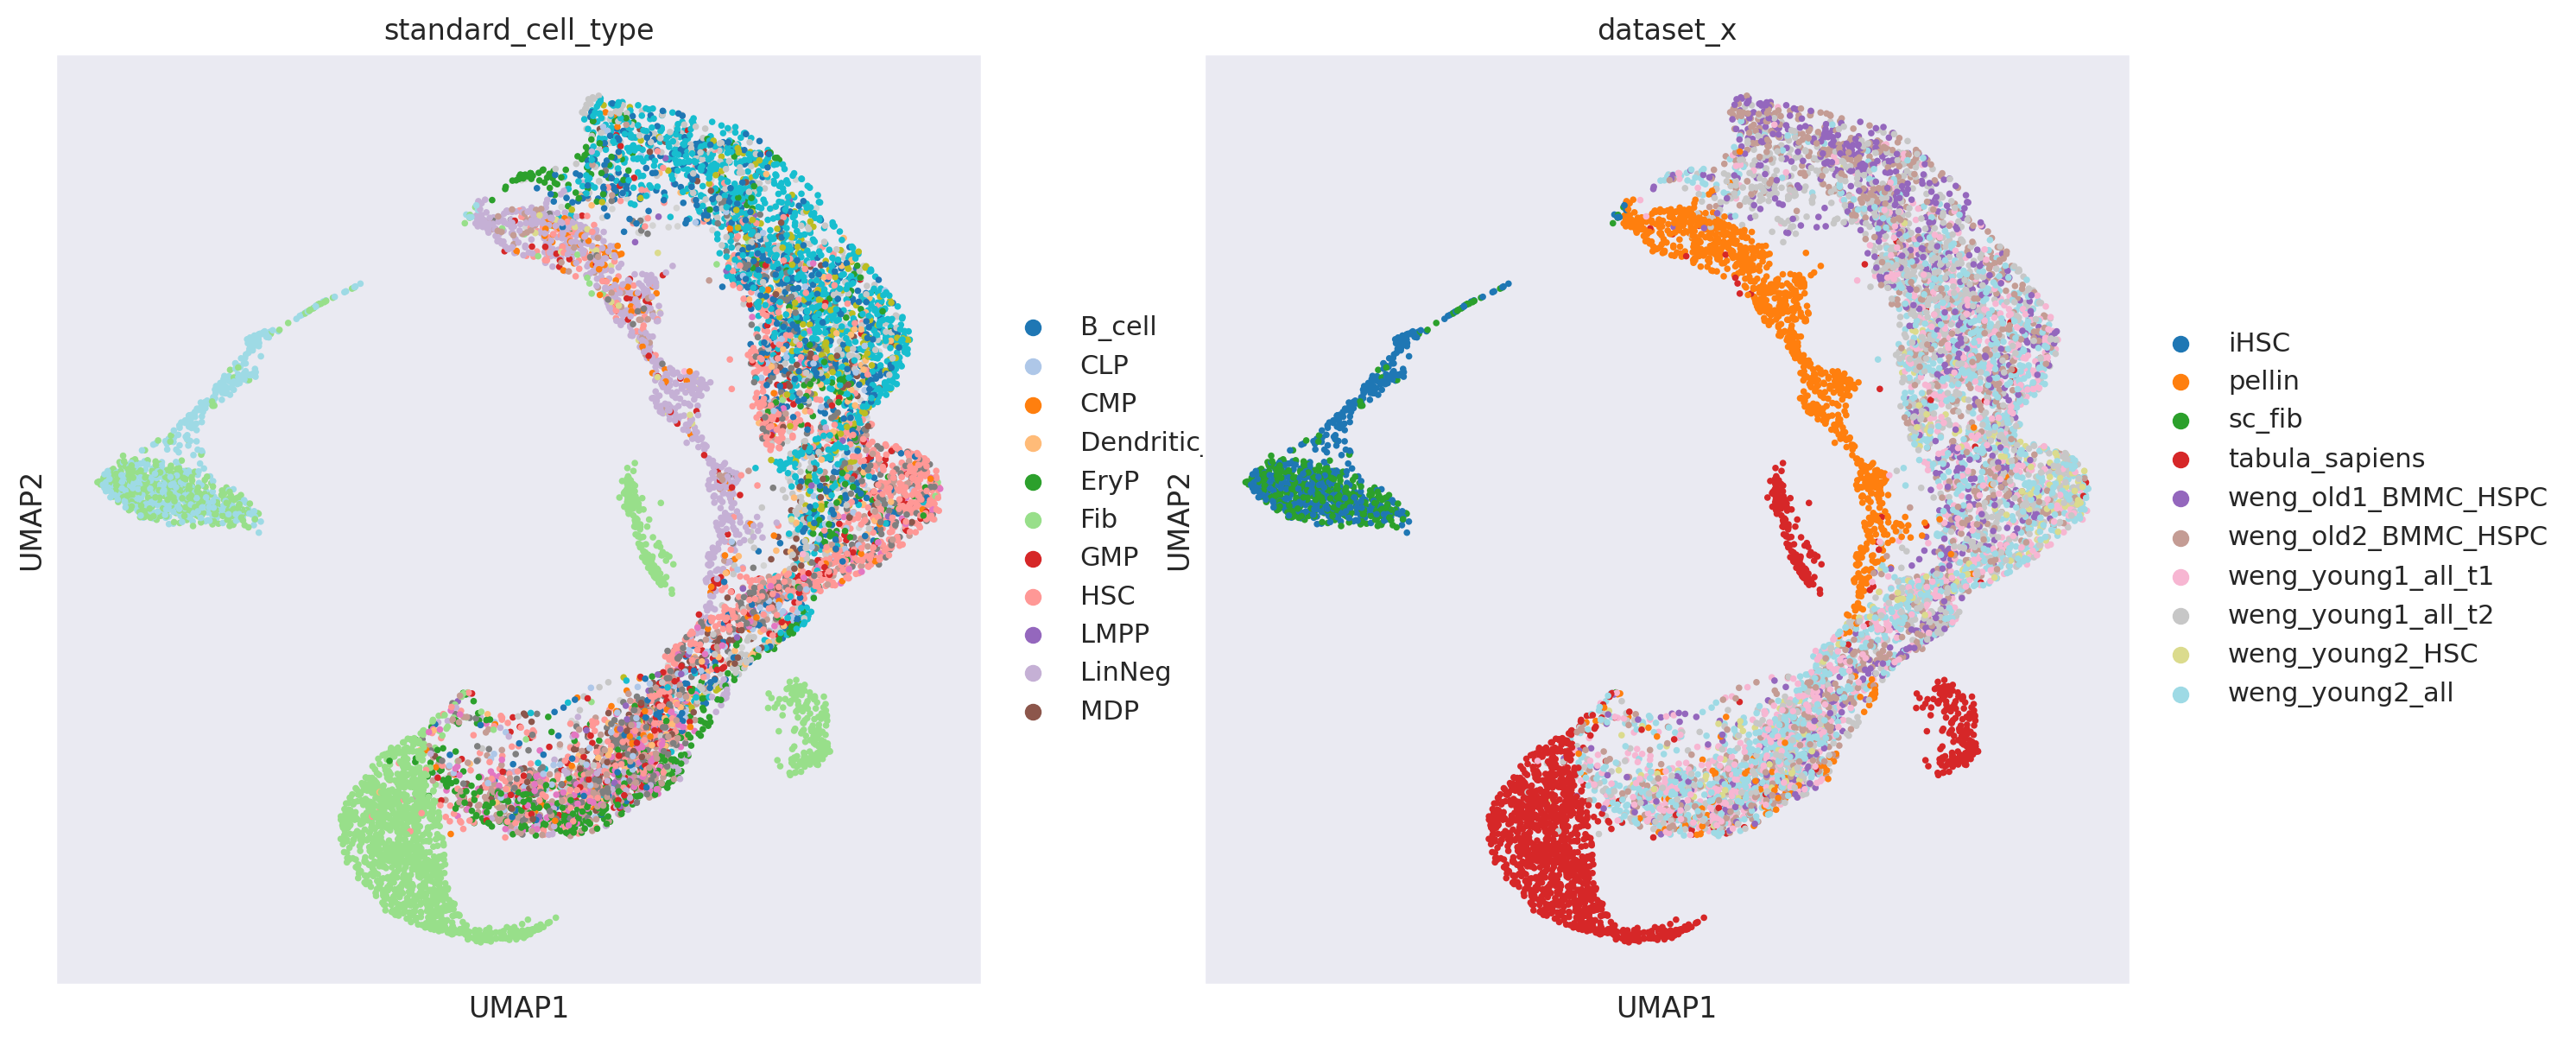

AnnData object with n_obs × n_vars = 10000 × 512
    obs: 'n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length'
    uns: 'pca', 'neighbors', 'umap', 'standard_cell_type_colors', 'dataset_x_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
sc.tl.pca(embs)
sc.pp.neighbors(embs)
sc.tl.umap(embs)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sc.pl.umap(
    embs,
    color=["standard_cell_type", "dataset_x"],
    palette='tab20',
    ncols=2,
    size=30,
)

embs

In [7]:
embs

AnnData object with n_obs × n_vars = 10000 × 512
    obs: 'n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length'
    uns: 'pca', 'neighbors', 'umap', 'standard_cell_type_colors', 'dataset_x_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
break